# Import packages

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

import OncoMarkAI as oma
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_50973/3646935697.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()

2024-02-21 22:01:22|INFO|plotting|Figure setting updated


In [3]:
rna_B2M = pd.read_csv("../OncoMarkAI/data/datasets/B2M_mRNA_expression_z-scores_relative_to_normal samples_logRNASeqV2RSEM.txt", sep="\t", index_col=1)[['B2M']]
rna_IGSF8 = pd.read_csv("../OncoMarkAI/data/datasets/IGSF8_mRNA_expression_z-scores_relative_to_normal samples_logRNASeqV2RSEM.txt", sep="\t", index_col=1)[['IGSF8']]
rna = rna_B2M.join(rna_IGSF8)
rna["PatientID"] = [idx[:-3] for idx in rna.index]

In [4]:
rna = rna[~rna["PatientID"].duplicated()]
patient_meta_cBio = pd.read_csv("../OncoMarkAI/data/datasets/combined_study_clinical_data_cBioPortal.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
rna.loc[:, "TCGA_project"] = rna["PatientID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])

In [5]:
def grouping(tmp, gene, low_boundary=-1, high_boundary=1):
    # Categorize the DataFrame
    tmp.loc[:, gene] = tmp[gene].replace("NP", np.nan).astype(float)
    conditions = [
        tmp[gene] <= low_boundary,
        (tmp[gene] > low_boundary) & (tmp[gene] <= high_boundary),
        tmp[gene] > high_boundary
    ]
    choices = [f'{gene} down-regulation', f'{gene} no-difference', f'{gene} up-regulation']

    return np.select(conditions, choices, default='unknown')

In [6]:
for gene in ["IGSF8", "B2M"]:
    rna[f'{gene}-groups'] = grouping(rna, gene, low_boundary=-1, high_boundary=1)

In [7]:
def calculate_fraction(rna, col):
    
    gene = col.replace("-groups", '')
    tmp = rna[[col, 'TCGA_project', 'PatientID']]
    tmp = tmp[tmp[col]!='unknown']
    result = tmp.groupby(['TCGA_project', col]).size() / tmp.groupby(['TCGA_project']).size()
    result = result.to_frame(f'Fraction_{gene}') * 100
    result = result.reset_index()
    result = result.pivot(index='TCGA_project', columns=col, values=f'Fraction_{gene}')
    return result

In [8]:
IGSF8_frac = calculate_fraction(rna, col='IGSF8-groups')
B2M_frac = calculate_fraction(rna, col='B2M-groups')

frac = IGSF8_frac.join(B2M_frac)

In [9]:
frac = frac.reindex(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC']).dropna()
frac = frac.sort_values(['B2M down-regulation'], ascending=False)
frac["B2M down-regulation & IGSF8 up-regulation"] = frac["B2M down-regulation"] + frac["IGSF8 up-regulation"]
frac = frac.sort_values(['B2M down-regulation & IGSF8 up-regulation'], ascending=False)

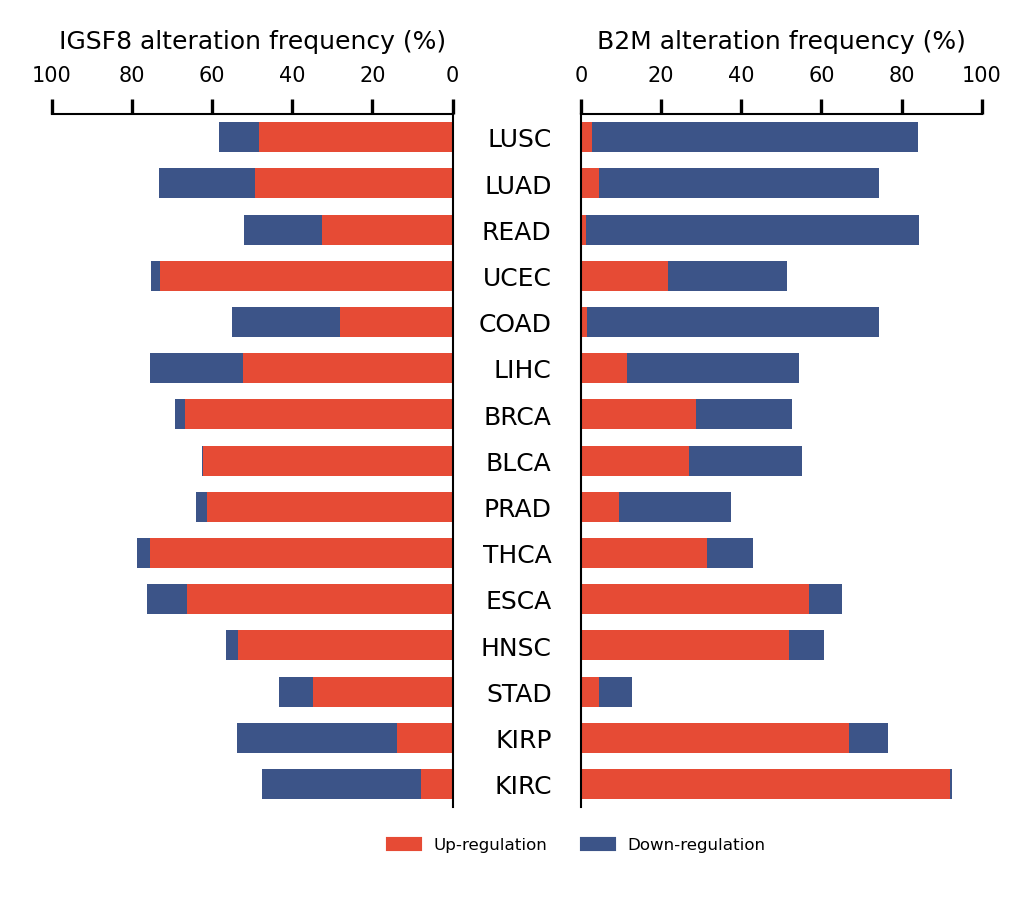

In [10]:
width = .65

for gene in ['B2M']:
    
    tmp = frac.loc[:, frac.columns.str.startswith(gene)]
    IGSF8_group = frac.loc[:, frac.columns.str.startswith('IGSF8')]
    tmp = tmp.join(IGSF8_group)
    tmp[f"IGSF8 up-regulation & {gene} down-regulation"] = tmp["IGSF8 up-regulation"] + tmp[f"{gene} down-regulation"]
    tmp = tmp.loc[::-1].dropna()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3), gridspec_kw={'wspace': .32}, )#width_ratios=[.49,.51]

    left = np.zeros(tmp.shape[0])
    for col, a, c in zip(['IGSF8 up-regulation', 'IGSF8 down-regulation'], [1, 1], (cmap.npg_palette(0), cmap.npg_palette(3))):
        p = axes[0].barh(tmp.reset_index().index, 
                         tmp[col], width, 
                         label=col, 
                         left=left, 
                         color=c, 
                         linewidth=.5,
                        ) #alpha=a, 

        left += tmp[col].values
        axes[0].set_xlim(100, 0)
        axes[0].set_ylim(-.5, frac.shape[0]-.5)
        axes[0].tick_params(left=False)  # remove the ticks
        axes[0].set_yticklabels("")  # remove the ticks
        axes[0].xaxis.set_ticks_position('top')
        axes[0].set(ylabel="", xlabel="IGSF8 alteration frequency (%)");
        axes[0].xaxis.set_label_position('top')
        axes[0].spines['bottom'].set_visible(False)
        axes[0].spines['left'].set_visible(False)        
        axes[0].legend("",frameon=False, loc='lower left', bbox_to_anchor=(-0.075, -0.1), ncols=2)
        
    left = np.zeros(tmp.shape[0])
    for col, a, c in zip([f'{gene} up-regulation', f'{gene} down-regulation'], [ .75, .75], (cmap.npg_palette(0), cmap.npg_palette(3))): #.25,
        p = axes[1].barh(tmp.reset_index().index, 
                         tmp[col], 
                         width, 
                   label=col, 
                   left=left, 
                   color=c, 
                   linewidth=.5, 
                        )

        left += tmp[col].values

    axes[1].set_ylim(-.5, frac.shape[0]-.5)
    axes[1].set_xlim(0., 100)
    axes[1].tick_params(left=False) # remove the ticks
    axes[1].xaxis.set_ticks_position('top')

    axes[1].set_yticks(tmp.reset_index().index, list(tmp.index),  fontsize=6, ha='right', rotation_mode='default'); #rotation=90, horizontalalignment='center',)
    # axes[1].legend(frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.1), ncols=2)
    axes[1].legend("", frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.1), ncols=2)
    axes[1].set(ylabel="", xlabel="B2M alteration frequency (%)");
    axes[1].xaxis.set_label_position('top')
    axes[1].spines['bottom'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    
    from matplotlib.patches import Patch
    handles = [
        Patch(edgecolor=fc, facecolor=fc, label=label, linewidth=.75) 
        for label, ec, fc in zip(['Up-regulation', 'Down-regulation'], [cmap.npg_palette(0), cmap.npg_palette(3)], [cmap.npg_palette(0), cmap.npg_palette(3)])
    ]
    axes[1].legend(handles=handles, loc=(-.5, -0.075), ncols=2, fontsize=4., frameon=False);

    plt.savefig(f"../figures/FigS3I.pdf", bbox_inches = "tight")

In [11]:
rna_B2M = pd.read_csv("../OncoMarkAI/data/datasets/B2M_mRNA_expression_z-scores_relative_to_normal samples_logRNASeqV2RSEM.txt", sep="\t", index_col=1)[['B2M']]
rna_IGSF8 = pd.read_csv("../OncoMarkAI/data/datasets/IGSF8_mRNA_expression_z-scores_relative_to_normal samples_logRNASeqV2RSEM.txt", sep="\t", index_col=1)[['IGSF8']]
rna = rna_B2M.join(rna_IGSF8)
rna["PatientID"] = [idx[:-3] for idx in rna.index]

rna = rna[~rna["PatientID"].duplicated()]
patient_meta_cBio = pd.read_csv("../OncoMarkAI/data/datasets/combined_study_clinical_data_cBioPortal.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
rna["TCGA_project"] = rna["PatientID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])

In [12]:
rna = rna[rna['TCGA_project'].isin(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SARC', 'KIRP', 'KIRC'])]

In [13]:
def contourplot(rna, pid, ax, gene="B2M"):
    
    tmp = rna.query('TCGA_project==@pid')
    tmp.loc[:, gene] = tmp[gene].replace("NP", np.nan).astype(float).copy()
    tmp.loc[:, "IGSF8"] = tmp["IGSF8"].replace("NP", np.nan).astype(float).copy()
    tmp = tmp.dropna()

    g = sns.kdeplot(x=tmp[gene], y=tmp["IGSF8"], cmap="Reds", fill=True, bw_adjust=.5, ax=ax)

    g.hlines(y=-1, xmin=-6, xmax=6, lw=.5, ls='--')
    g.hlines(y=1, xmin=-6, xmax=6, lw=.5, ls='--')
    g.vlines(x=-1, ymin=-6, ymax=6, lw=.5, ls='--')
    g.vlines(x=1, ymin=-6, ymax=6, lw=.5, ls='--')
        
    g.set(xlim=(-6,6), ylim=(-6,6), title=pid)
    ax.set_xlabel(f"{gene} z-scores\nrelative to normal samples")
    ax.set_ylabel("IGSF8 z-scores\nrelative to normal samples")
    g.set(xlim=(-6,6), ylim=(-6,6), title=pid)

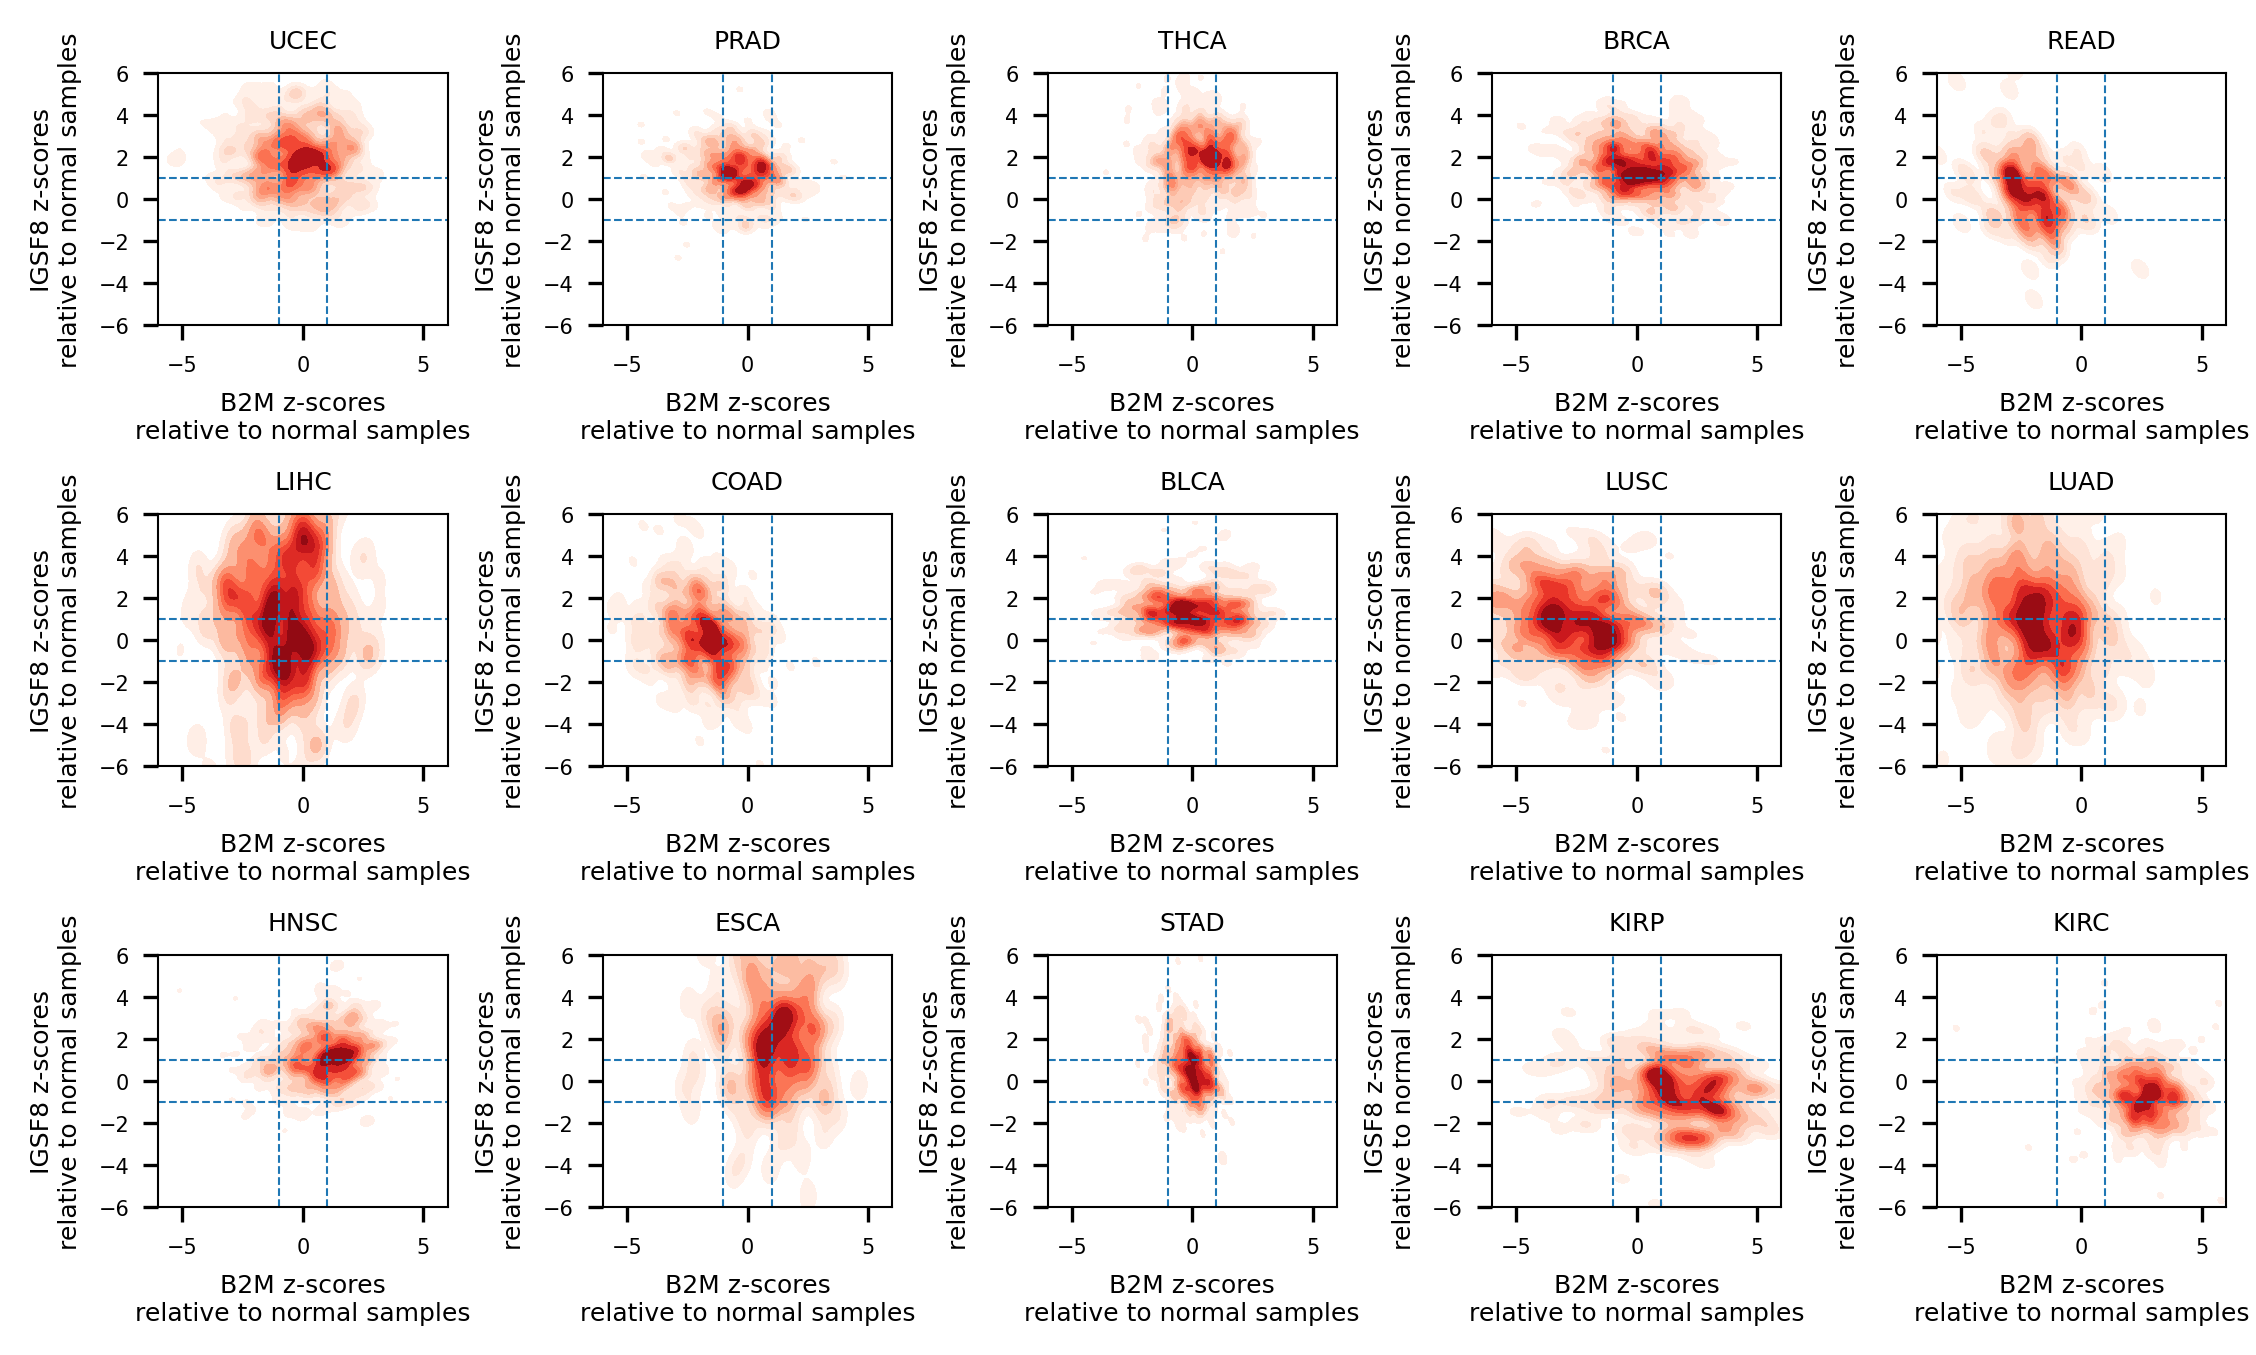

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(7.5, 4.5))
i = 0
for pid in ['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'KIRP', 'KIRC']:
    row = i//5
    col = i % 5
    
    contourplot(rna, pid, axes[row, col], "B2M")
    i += 1
plt.savefig("../figures/FigS3H.pdf", bbox_inches = "tight")

# B2M KO on IGSF8 expression in vitro

In [15]:
B2M_KO = pd.read_csv("../OncoMarkAI/data/datasets/GSE154996_FPKM_Matrix.txt.gz", sep="\t", index_col=0)
B2M_KO = B2M_KO[["M202.B2M.KO.Ctrl.FPKM", "M202.Ctrl.FPKM", "M233.B2M.KO.Ctrl.FPKM", "M233.Ctrl.FPKM"]]
B2M_KO["LogFC (M202)"] = np.log(B2M_KO["M202.B2M.KO.Ctrl.FPKM"] / B2M_KO["M202.Ctrl.FPKM"])
B2M_KO["LogFC (M233)"] = np.log(B2M_KO["M233.B2M.KO.Ctrl.FPKM"] / B2M_KO["M233.Ctrl.FPKM"])

/Users/caibin/miniconda3/envs/IGSF8/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/caibin/miniconda3/envs/IGSF8/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


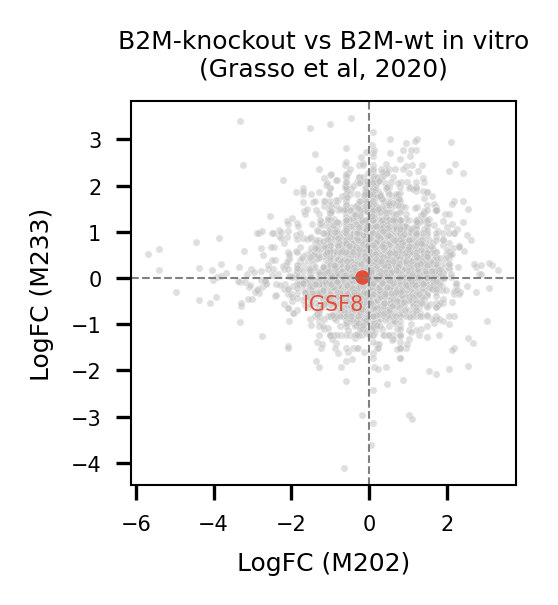

In [16]:
plt.figure(figsize=(1.8, 2))
ax = sns.scatterplot(data=B2M_KO.dropna(),
                     x="LogFC (M202)",
                     y="LogFC (M233)",
                     color="silver",
                     alpha=.5,
                     s=3
                    )
ax.axvline(0, ls="--", lw=.5, color="grey")
ax.axhline(0, ls="--", lw=.5, color="grey")
plt.scatter(x=B2M_KO.loc["IGSF8", "LogFC (M202)"],
            y=B2M_KO.loc["IGSF8", "LogFC (M233)"],
            color=cmap.npg_palette(0),
            s=6
           )

plt.text(-1.7, -.7, "IGSF8", color=cmap.npg_palette(0), fontsize=5)
plt.title("B2M-knockout vs B2M-wt in vitro\n(Grasso et al, 2020)")
plt.savefig("../figures/FigS2H.pdf", bbox_inches = "tight")